# Antenna Array Beam Steering - Complete Workflow

This notebook provides a **complete end-to-end workflow** for automatic beam steering of antenna arrays using PyAEDT and HFSS. It demonstrates the complete pipeline from geometry extraction to pattern validation, integrating all the techniques discovered during our development process.

## 🎯 **What This Notebook Does**

This system automatically:
1. **Analyzes your HFSS array design** - extracts element positions regardless of port naming or model units
2. **Extracts design parameters** - gets actual model units (mm/m/mil/etc) and design frequency from HFSS
3. **Calculates beam steering phases** - uses actual geometry and array theory with proper unit conversion
4. **Updates HFSS excitations in real-time** - no need to re-solve for pattern changes
5. **Validates steering accuracy** - compares achieved vs target beam direction
6. **Provides visual feedback** - plots radiation patterns with steering results

## 🔬 **Scientific Foundation**

**Beam Steering Theory:**
- **Progressive Phase Shift**: φₙ = -k·dₙ·sin(θ₀)
- **k**: Wavenumber = 2π/λ
- **dₙ**: Distance of element n from reference (converted to meters)
- **θ₀**: Target beam direction

**Key Innovation**: Uses **actual element positions** from HFSS geometry with **automatic unit conversion** and **design frequency extraction**.

## 🏗️ **Architecture Overview**

1. **ArrayGeometryAnalyzer** - Extracts physical array configuration with unit handling
2. **BeamSteeringManager** - Handles excitation calculations using actual design frequency
3. **Specification Interface** - Natural language-like commands
4. **Validation System** - Measures actual steering performance

## 💡 **Key Features**

- ✅ **Automatic array geometry detection** - works with any linear array
- ✅ **Automatic unit conversion** - handles mm, meters, mils, inches, etc.
- ✅ **Design frequency extraction** - uses actual HFSS setup frequency
- ✅ **Physical port position extraction** - uses HFSS IntLine.GeometryPosition
- ✅ **Real-time beam steering** - post-processing variables for instant updates
- ✅ **Pattern validation and visualization** - polar plots with steering verification
- ✅ **Specification-driven interface** - simple command structure
- ✅ **Comprehensive testing framework** - automated multi-angle validation
- 🚧 **Extensible design** - ready for null steering, SLL control, etc.

## 🎮 **How to Use**

1. **Connect to your HFSS project** (Section 1)
2. **Run geometry analysis** (Section 2) 
3. **Test beam steering** (Section 6-7)
4. **Use interactive interface** (Section 7)

**Simple Example:**
```python
# Steer beam to 30 degrees (uses design frequency automatically)
spec = {"type": "beam_steering", "angle": 30}
result = synthesize_pattern(spec, beam_manager)

# Or specify custom frequency
spec = {"type": "beam_steering", "angle": 30, "frequency": 12e9}
result = synthesize_pattern(spec, beam_manager)
```

## 🔧 **Units and Frequency Handling**

This notebook automatically:
- **Detects model units** from `hfss.modeler.model_units`
- **Converts all positions to meters** using simple conversion factors
- **Extracts design frequency** from `hfss.setups[0].props["Frequency"]`
- **Supports all HFSS units**: mm, meters, mils, inches, cm, micrometers, etc.
- **Parses frequency strings**: "10GHz", "2.4GHz", etc.

## 1. Setup and Configuration

This section handles the basic setup: importing required libraries, configuring HFSS connection parameters, and establishing the connection to your HFSS project.

### 📚 **What We're Importing**
- **PyAEDT**: The main interface to ANSYS HFSS
- **NumPy**: For array mathematics and phase calculations  
- **Matplotlib**: For radiation pattern visualization
- **Typing**: For proper code documentation and type hints

### 🔧 **Configuration Requirements**
- **HFSS Project**: Must be a solved array design with lumped ports
- **Student Version**: Set to `True` if using AEDT Student
- **Non-Graphical**: Set to `False` to see HFSS GUI (helpful for debugging)

In [19]:
# Core imports
from ansys.aedt.core import Hfss
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from typing import Dict, List, Tuple, Optional

print("✅ All imports successful!")

✅ All imports successful!


In [20]:
# Configuration parameters
PROJECT_PATH = r"C:\Mac\Home\Documents\HFSS_Projects\array_example\planar_flared_dipole_array.aedt"
AEDT_VERSION = "2024.2"
NON_GRAPHICAL = False
SPEED_OF_LIGHT = 299792458  # m/s

print(f"📋 Configuration:")
print(f"  Project Path: {PROJECT_PATH}")
print(f"  AEDT Version: {AEDT_VERSION}")
print(f"  Non-Graphical: {NON_GRAPHICAL}")

if os.path.exists(PROJECT_PATH):
    print(f"  ✓ Project file found")
else:
    print(f"  ⚠ Project file not found - please update PROJECT_PATH")

📋 Configuration:
  Project Path: C:\Mac\Home\Documents\HFSS_Projects\array_example\planar_flared_dipole_array.aedt
  AEDT Version: 2024.2
  Non-Graphical: False
  ✓ Project file found


In [21]:
# Helper functions for units and frequency extraction
def get_model_units(hfss):
    """Extract model units from HFSS design."""
    try:
        units = hfss.modeler.model_units
        print(f"📏 Model units: {units}")
        return units
    except Exception as e:
        print(f"❌ Error getting model units: {e}")
        return "mm"  # Default fallback

def convert_to_meters(values, from_units):
    """Convert position values to meters using simple conversion factors."""
    try:
        # Conversion factors to meters
        unit_factors = {
            "m": 1.0,
            "meter": 1.0,
            "meters": 1.0,
            "mm": 0.001,
            "millimeter": 0.001,
            "millimeters": 0.001,
            "cm": 0.01,
            "centimeter": 0.01,
            "centimeters": 0.01,
            "dm": 0.1,
            "decimeter": 0.1,
            "decimeters": 0.1,
            "km": 1000.0,
            "kilometer": 1000.0,
            "kilometers": 1000.0,
            "in": 0.0254,
            "inch": 0.0254,
            "inches": 0.0254,
            "ft": 0.3048,
            "foot": 0.3048,
            "feet": 0.3048,
            "mil": 0.0000254,
            "mils": 0.0000254,
            "uin": 0.0000000254,  # microinch
            "microinch": 0.0000000254,
            "um": 0.000001,  # micrometer
            "micrometer": 0.000001,
            "micrometers": 0.000001,
            "nm": 0.000000001,  # nanometer
            "nanometer": 0.000000001,
            "nanometers": 0.000000001
        }
        
        # Normalize unit string
        unit_key = from_units.lower().strip()
        
        if unit_key in unit_factors:
            factor = unit_factors[unit_key]
            print(f"  🔄 Converting from {from_units} to meters (factor: {factor})")
            
            if isinstance(values, (list, tuple)):
                return [v * factor for v in values]
            else:
                return values * factor
        else:
            print(f"⚠️ Unknown unit '{from_units}', assuming meters")
            return values
            
    except Exception as e:
        print(f"❌ Unit conversion error: {e}")
        print(f"⚠️ Assuming values are already in meters")
        return values

def get_design_frequency(hfss):
    """Extract design frequency from HFSS setup."""
    try:
        if hasattr(hfss, 'setups') and hfss.setups:
            setup = hfss.setups[0]  # Get first setup
            if hasattr(setup, 'props') and 'Frequency' in setup.props:
                freq_str = setup.props['Frequency']
                freq_hz = parse_frequency_string(freq_str)
                print(f"📡 Design frequency: {freq_str} ({freq_hz/1e9:.1f} GHz)")
                return freq_hz
            else:
                print("⚠️ No frequency found in setup properties")
        else:
            print("⚠️ No setups found in design")
        
        print("⚠️ Using default frequency: 10 GHz")
        return 10e9
        
    except Exception as e:
        print(f"❌ Error getting design frequency: {e}")
        print("⚠️ Using default frequency: 10 GHz")
        return 10e9

def parse_frequency_string(freq_str):
    """Parse frequency string like '10GHz' to Hz."""
    try:
        # Remove spaces and convert to lowercase
        freq_str = freq_str.replace(" ", "").lower()
        
        # Extract number and unit using regex
        match = re.match(r'([0-9.]+)([a-z]+)', freq_str)
        if match:
            value = float(match.group(1))
            unit = match.group(2)
            
            # Convert to Hz based on unit
            if unit in ['hz']:
                return value
            elif unit in ['khz']:
                return value * 1e3
            elif unit in ['mhz']:
                return value * 1e6
            elif unit in ['ghz']:
                return value * 1e9
            elif unit in ['thz']:
                return value * 1e12
            else:
                print(f"⚠️ Unknown frequency unit: {unit}, assuming GHz")
                return value * 1e9  # Assume GHz
        else:
            # Try to extract just the number (assume GHz)
            value = float(re.findall(r'[0-9.]+', freq_str)[0])
            print(f"⚠️ No unit found in '{freq_str}', assuming GHz")
            return value * 1e9
            
    except Exception as e:
        print(f"❌ Error parsing frequency '{freq_str}': {e}")
        return 10e9  # Default fallback

print("✅ Helper functions for units and frequency defined!")

✅ Helper functions for units and frequency defined!


In [22]:
# Connect to HFSS
try:
    print("🔌 Connecting to HFSS...")
    
    hfss = Hfss(
        project=PROJECT_PATH,
        version=AEDT_VERSION,
        non_graphical=NON_GRAPHICAL,
        student_version=True,
        remove_lock=True
    )
    
    print("✅ Successfully connected to HFSS!")
    print(f"  Project: {hfss.project_name}")
    print(f"  Design: {hfss.design_name}")
    print(f"  Solution Type: {hfss.solution_type}")
    
    # Get basic array info
    ports = hfss.ports
    print(f"  Ports ({len(ports)}): {ports}")
    
except Exception as e:
    print(f"❌ Failed to connect to HFSS: {e}")
    hfss = None

🔌 Connecting to HFSS...
PyAEDT INFO: Python version 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)].
PyAEDT INFO: Parsing C:\Mac\Home\Documents\HFSS_Projects\array_example\planar_flared_dipole_array.aedt.
PyAEDT INFO: PyAEDT version 0.15.0.
PyAEDT INFO: Returning found Desktop session with PID 3816!
PyAEDT INFO: Project planar_flared_dipole_array set to active.
PyAEDT INFO: Active Design set to HFSSDesign1
PyAEDT INFO: File C:\Mac\Home\Documents\HFSS_Projects\array_example\planar_flared_dipole_array.aedt correctly loaded. Elapsed time: 0m 0sec
PyAEDT INFO: Active Design set to HFSSDesign1
PyAEDT INFO: Aedt Objects correctly read
✅ Successfully connected to HFSS!
  Project: planar_flared_dipole_array
  Design: HFSSDesign1
  Solution Type: Modal
  Ports (5): ['1', '2', '3', '4', '5']


In [5]:
class ArrayGeometryAnalyzer:
    """Extract and analyze physical array configuration from HFSS design."""
    
    def __init__(self, hfss):
        self.hfss = hfss
        self.port_positions = {}
        self.port_positions_meters = {}  # Store converted positions
        self.sorted_ports = []
        self.array_axis = None
        self.element_spacing = None
        self.reference_element = None
        self.model_units = None
        
    def extract_port_positions(self):
        """Extract port positions using IntLine.GeometryPosition method."""
        print("🎯 Extracting port positions from HFSS geometry...")
        
        # Get model units first
        self.model_units = get_model_units(self.hfss)
        print(f"  📏 Model units detected: {self.model_units}")
        
        port_positions = {}
        port_positions_meters = {}
        
        try:
            boundaries = self.hfss.boundaries
            
            for boundary in boundaries:
                boundary_name = getattr(boundary, 'name', 'Unknown')
                boundary_type = getattr(boundary, 'type', 'Unknown')
                
                if 'port' in str(boundary_type).lower():
                    print(f"  🔌 Analyzing port: {boundary_name}")
                    
                    if hasattr(boundary, 'props') and boundary.props:
                        props = boundary.props
                        
                        if 'Modes' in props and 'Mode1' in props['Modes']:
                            mode = props['Modes']['Mode1']
                            
                            if 'IntLine' in mode and 'GeometryPosition' in mode['IntLine']:
                                geo_positions = mode['IntLine']['GeometryPosition']
                                
                                positions = []
                                for pos in geo_positions:
                                    x = float(pos['XPosition'])
                                    y = float(pos['YPosition']) 
                                    z = float(pos['ZPosition'])
                                    positions.append([x, y, z])
                                
                                # Calculate port position (midpoint for lumped ports)
                                if len(positions) >= 2:
                                    midpoint = np.mean(positions, axis=0)
                                    port_position = midpoint.tolist()
                                elif len(positions) == 1:
                                    port_position = positions[0]
                                else:
                                    print(f"    ❌ No geometry positions found for {boundary_name}")
                                    continue
                                
                                # Store original position in model units
                                port_positions[boundary_name] = {
                                    'position': port_position,
                                    'x': port_position[0],
                                    'y': port_position[1],
                                    'z': port_position[2]
                                }
                                
                                # Convert to meters for calculations
                                position_meters = convert_to_meters(port_position, self.model_units)
                                port_positions_meters[boundary_name] = {
                                    'position': position_meters,
                                    'x': position_meters[0],
                                    'y': position_meters[1],
                                    'z': position_meters[2]
                                }
                                
                                print(f"    ✅ Position: [{port_position[0]:.3f}, {port_position[1]:.3f}, {port_position[2]:.3f}] {self.model_units}")
                                print(f"       → Meters: [{position_meters[0]:.6f}, {position_meters[1]:.6f}, {position_meters[2]:.6f}] m")
            
            self.port_positions = port_positions
            self.port_positions_meters = port_positions_meters
            print(f"\n✅ Successfully extracted {len(port_positions)} port positions!")
            return port_positions
            
        except Exception as e:
            print(f"❌ Error extracting port positions: {e}")
            return {}
    
    def determine_array_axis(self):
        """Determine which axis the array is oriented along."""
        if not self.port_positions_meters:
            print("❌ No port positions available")
            return None
            
        positions = np.array([info['position'] for info in self.port_positions_meters.values()])
        
        # Calculate variation along each axis
        x_var = np.var(positions[:, 0])
        y_var = np.var(positions[:, 1])
        z_var = np.var(positions[:, 2])
        
        # Axis with highest variation is the array axis
        variances = {'X': x_var, 'Y': y_var, 'Z': z_var}
        self.array_axis = max(variances, key=variances.get)
        
        print(f"📐 Array axis determination (using meter coordinates):")
        print(f"  X variance: {x_var:.6f} m²")
        print(f"  Y variance: {y_var:.6f} m²")
        print(f"  Z variance: {z_var:.6f} m²")
        print(f"  → Array oriented along {self.array_axis}-axis")
        
        return self.array_axis
    
    def sort_ports_by_position(self):
        """Sort ports by their physical position along the array axis."""
        if not self.port_positions_meters or not self.array_axis:
            print("❌ Need port positions and array axis first")
            return []
        
        # Get axis index (0=X, 1=Y, 2=Z)
        axis_index = {'X': 0, 'Y': 1, 'Z': 2}[self.array_axis]
        
        # Sort ports by position along array axis (using meter coordinates)
        port_items = list(self.port_positions_meters.items())
        port_items.sort(key=lambda item: item[1]['position'][axis_index])
        
        self.sorted_ports = [port_name for port_name, _ in port_items]
        
        print(f"📋 Ports sorted by {self.array_axis}-position:")
        for i, port in enumerate(self.sorted_ports):
            pos_original = self.port_positions[port]['position']
            pos_meters = self.port_positions_meters[port]['position']
            print(f"  {i+1}. {port}: [{pos_original[0]:.3f}, {pos_original[1]:.3f}, {pos_original[2]:.3f}] {self.model_units}")
            print(f"     → [{pos_meters[0]:.6f}, {pos_meters[1]:.6f}, {pos_meters[2]:.6f}] m")
        
        return self.sorted_ports
    
    def calculate_element_spacing(self, frequency_hz=None):
        """Calculate element spacing in meters and wavelengths."""
        if len(self.sorted_ports) < 2:
            print("❌ Need at least 2 elements to calculate spacing")
            return None
        
        # Get frequency - use design frequency if not specified
        if frequency_hz is None:
            frequency_hz = get_design_frequency(self.hfss)
        
        # Get positions of first two elements in meters
        pos1 = np.array(self.port_positions_meters[self.sorted_ports[0]]['position'])
        pos2 = np.array(self.port_positions_meters[self.sorted_ports[1]]['position'])
        
        # Calculate spacing
        spacing_m = np.linalg.norm(pos2 - pos1)
        wavelength_m = SPEED_OF_LIGHT / frequency_hz
        spacing_lambda = spacing_m / wavelength_m
        
        self.element_spacing = {
            'meters': spacing_m,
            'wavelengths': spacing_lambda,
            'frequency': frequency_hz
        }
        
        print(f"📏 Element spacing analysis:")
        print(f"  Frequency: {frequency_hz/1e9:.1f} GHz")
        print(f"  Wavelength: {wavelength_m*1000:.1f} mm")
        print(f"  Spacing: {spacing_m*1000:.1f} mm ({spacing_lambda:.3f}λ)")
        
        return self.element_spacing
    
    def set_reference_element(self, reference_port=None):
        """Set reference element for phase calculations."""
        if reference_port is None:
            # Use first element as reference
            self.reference_element = self.sorted_ports[0] if self.sorted_ports else None
        else:
            if reference_port in self.sorted_ports:
                self.reference_element = reference_port
            else:
                print(f"❌ Port {reference_port} not found in sorted ports")
                return None
        
        print(f"📍 Reference element set to: {self.reference_element}")
        return self.reference_element
    
    def analyze_complete_geometry(self, frequency_hz=None):
        """Run complete geometry analysis pipeline."""
        print("🔬 COMPLETE ARRAY GEOMETRY ANALYSIS")
        print("=" * 50)
        
        # Step 1: Extract positions
        positions = self.extract_port_positions()
        if not positions:
            return False
        
        # Step 2: Determine array axis
        axis = self.determine_array_axis()
        if not axis:
            return False
        
        # Step 3: Sort ports
        sorted_ports = self.sort_ports_by_position()
        if not sorted_ports:
            return False
        
        # Step 4: Calculate spacing (use design frequency if not specified)
        if frequency_hz is None:
            frequency_hz = get_design_frequency(self.hfss)
        spacing = self.calculate_element_spacing(frequency_hz)
        if not spacing:
            return False
        
        # Step 5: Set reference
        ref = self.set_reference_element()
        if not ref:
            return False
        
        print(f"\n✅ Geometry analysis complete!")
        print(f"  Array: {len(self.sorted_ports)} elements along {self.array_axis}-axis")
        print(f"  Model units: {self.model_units}")
        print(f"  Spacing: {spacing['wavelengths']:.3f}λ at {frequency_hz/1e9:.1f} GHz")
        print(f"  Reference: {self.reference_element}")
        
        return True

print("✅ ArrayGeometryAnalyzer class defined!")

✅ ArrayGeometryAnalyzer class defined!


In [23]:
# Test the geometry analyzer
if hfss is not None:
    print("🧪 Testing ArrayGeometryAnalyzer...")
    
    geometry = ArrayGeometryAnalyzer(hfss)
    success = geometry.analyze_complete_geometry(frequency_hz=1.9e9)
    
    if success:
        print("\n🎉 Array geometry analysis successful!")
    else:
        print("\n❌ Array geometry analysis failed")
else:
    print("❌ No HFSS connection for testing")

🧪 Testing ArrayGeometryAnalyzer...
🔬 COMPLETE ARRAY GEOMETRY ANALYSIS
🎯 Extracting port positions from HFSS geometry...
PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec
📏 Model units: mm
  📏 Model units detected: mm
  🔌 Analyzing port: 1
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -200.000, -28.605] mm
       → Meters: [-0.000000, -0.200000, -0.028605] m
  🔌 Analyzing port: 2
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -100.000, -28.605] mm
       → Meters: [-0.000000, -0.100000, -0.028605] m
  🔌 Analyzing port: 3
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, 0.000, -28.605] mm
       → Meters: [-0.000000, 0.000000, -0.028605] m
  🔌 Analyzing port: 4
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, 100.000, -28.605] mm
       → Meters: [-0.000000, 0.100000, -0.028605] m
  🔌 Analyzing port: 5
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Positio

In [24]:
class BeamSteeringManager:
    """Complete beam steering implementation with real-time excitation control."""
    
    def __init__(self, hfss):
        self.hfss = hfss
        self.geometry = ArrayGeometryAnalyzer(hfss)
        self.excitation_variables_setup = False
        self.design_frequency = None
        
    def setup_excitation_variables(self):
        """Set up post-processing variables for all ports."""
        print("🔧 Setting up excitation variables...")
        
        try:
            ports = self.hfss.ports
            
            # Create post-processing variables for each port
            for port in ports:
                mag_var = f"Port{port}_Magnitude"
                phase_var = f"Port{port}_Phase"
                
                # Initialize with default values
                success1 = self.hfss.variable_manager.set_variable(mag_var, "1W", is_post_processing=True)
                success2 = self.hfss.variable_manager.set_variable(phase_var, "0deg", is_post_processing=True)
                
                if success1 and success2:
                    print(f"  ✅ {port}: {mag_var}, {phase_var}")
                else:
                    print(f"  ❌ {port}: Variable creation failed")
            
            # Link to sources WITHOUT $ prefix
            sources = {f"{port}:1": (f"Port{port}_Magnitude", f"Port{port}_Phase") for port in ports}
            self.hfss.edit_sources(sources)
            
            self.excitation_variables_setup = True
            print(f"✅ Excitation variables setup complete for {len(ports)} ports!")
            return True
            
        except Exception as e:
            print(f"❌ Error setting up excitation variables: {e}")
            return False
    
    def calculate_steering_phases(self, theta_deg, frequency_hz=None):
        """Calculate required phases for beam steering to specified angle."""
        if not self.geometry.sorted_ports or not self.geometry.port_positions_meters:
            print("❌ Array geometry not analyzed yet")
            return None
        
        # Use design frequency if not specified
        if frequency_hz is None:
            if self.design_frequency is None:
                self.design_frequency = get_design_frequency(self.hfss)
            frequency_hz = self.design_frequency
        
        print(f"🧮 Calculating phases for {theta_deg}° beam steering...")
        
        # Get array parameters
        axis_index = {'X': 0, 'Y': 1, 'Z': 2}[self.geometry.array_axis]
        wavelength = SPEED_OF_LIGHT / frequency_hz
        k = 2 * np.pi / wavelength  # wavenumber
        theta_rad = np.deg2rad(theta_deg)
        
        # Get reference element position (in meters)
        ref_position = self.geometry.port_positions_meters[self.geometry.reference_element]['position'][axis_index]
        
        # Calculate phases for each element
        phases = {}
        
        print(f"  Frequency: {frequency_hz/1e9:.1f} GHz")
        print(f"  Wavelength: {wavelength*1000:.1f} mm")
        print(f"  Target angle: {theta_deg}°")
        print(f"  Reference: {self.geometry.reference_element}")
        print(f"  Model units: {self.geometry.model_units}")
        
        for port in self.geometry.sorted_ports:
            # Get element position relative to reference (in meters)
            element_pos = self.geometry.port_positions_meters[port]['position'][axis_index]
            relative_pos = element_pos - ref_position  # Distance in meters
            
            # Calculate required phase shift
            # φ = -k * d * sin(θ) where d is distance from reference in meters
            phase_rad = -k * relative_pos * np.sin(theta_rad)
            phase_deg = np.rad2deg(phase_rad)
            
            phases[port] = phase_deg
            
            print(f"    {port}: pos={relative_pos*1000:.1f}mm → phase={phase_deg:.1f}°")
        
        return phases
    
    def apply_excitations(self, magnitudes, phases):
        """Apply calculated magnitudes and phases to HFSS."""
        if not self.excitation_variables_setup:
            print("❌ Excitation variables not set up")
            return False
        
        print(f"🎯 Applying excitations to {len(phases)} ports...")
        
        success_count = 0
        
        for port in phases.keys():
            try:
                mag_var = f"Port{port}_Magnitude"
                phase_var = f"Port{port}_Phase"
                
                mag_val = magnitudes.get(port, "1W")
                phase_val = f"{phases[port]:.1f}deg"
                
                success1 = self.hfss.variable_manager.set_variable(mag_var, mag_val, is_post_processing=True)
                success2 = self.hfss.variable_manager.set_variable(phase_var, phase_val, is_post_processing=True)
                
                if success1 and success2:
                    success_count += 1
                    print(f"  ✅ {port}: {mag_val}, {phase_val}")
                else:
                    print(f"  ❌ {port}: Update failed")
                    
            except Exception as e:
                print(f"  ❌ {port}: Error {e}")
        
        print(f"✅ Applied excitations to {success_count}/{len(phases)} ports")
        return success_count == len(phases)
    
    def steer_beam_to_angle(self, theta_deg, frequency_hz=None, amplitude_taper="uniform"):
        """Main function: Steer beam to specified angle."""
        print(f"\n🎯 BEAM STEERING TO {theta_deg}°")
        print("=" * 40)
        
        # Use design frequency if not specified
        if frequency_hz is None:
            if self.design_frequency is None:
                self.design_frequency = get_design_frequency(self.hfss)
            frequency_hz = self.design_frequency
            print(f"📡 Using design frequency: {frequency_hz/1e9:.1f} GHz")
        
        # Ensure geometry is analyzed
        if not self.geometry.sorted_ports:
            print("🔬 Running geometry analysis first...")
            if not self.geometry.analyze_complete_geometry(frequency_hz):
                print("❌ Geometry analysis failed")
                return False
        
        # Ensure excitation variables are set up
        if not self.excitation_variables_setup:
            if not self.setup_excitation_variables():
                print("❌ Excitation setup failed")
                return False
        
        # Calculate steering phases
        phases = self.calculate_steering_phases(theta_deg, frequency_hz)
        if phases is None:
            print("❌ Phase calculation failed")
            return False
        
        # Set up magnitudes (uniform for now)
        magnitudes = {port: "1W" for port in phases.keys()}
        
        # Apply to HFSS
        success = self.apply_excitations(magnitudes, phases)
        if success:
            print(f"\n🎉 Beam successfully steered to {theta_deg}°!")
        else:
            print(f"\n❌ Beam steering failed")
        
        return success
    
    def get_current_excitations(self):
        """Get current excitation values from HFSS."""
        try:
            post_vars = self.hfss.variable_manager.post_processing_variables
            current = {}
            
            for port in self.hfss.ports:
                mag_var = f"Port{port}_Magnitude"
                phase_var = f"Port{port}_Phase"
                
                if mag_var in post_vars and phase_var in post_vars:
                    current[port] = {
                        'magnitude': post_vars[mag_var].evaluated_value,
                        'phase': post_vars[phase_var].evaluated_value
                    }
            
            return current
            
        except Exception as e:
            print(f"❌ Error getting current excitations: {e}")
            return {}

print("✅ BeamSteeringManager class defined!")

✅ BeamSteeringManager class defined!


In [25]:
# Test the beam steering manager
if hfss is not None:
    print("🧪 Testing BeamSteeringManager...")
    
    beam_mgr = BeamSteeringManager(hfss)
    
    # Test beam steering to 30 degrees
    success = beam_mgr.steer_beam_to_angle(30, frequency_hz=1.9e9)
    
    if success:
        print("\n📊 Current excitation state:")
        current = beam_mgr.get_current_excitations()
        for port, values in current.items():
            print(f"  {port}: {values['magnitude']}, {values['phase']}")
    
else:
    print("❌ No HFSS connection for testing")

🧪 Testing BeamSteeringManager...

🎯 BEAM STEERING TO 30°
🔬 Running geometry analysis first...
🔬 COMPLETE ARRAY GEOMETRY ANALYSIS
🎯 Extracting port positions from HFSS geometry...
📏 Model units: mm
  📏 Model units detected: mm
  🔌 Analyzing port: 1
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -200.000, -28.605] mm
       → Meters: [-0.000000, -0.200000, -0.028605] m
  🔌 Analyzing port: 2
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -100.000, -28.605] mm
       → Meters: [-0.000000, -0.100000, -0.028605] m
  🔌 Analyzing port: 3
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, 0.000, -28.605] mm
       → Meters: [-0.000000, 0.000000, -0.028605] m
  🔌 Analyzing port: 4
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, 100.000, -28.605] mm
       → Meters: [-0.000000, 0.100000, -0.028605] m
  🔌 Analyzing port: 5
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, 

## 4. Far Field Data Extraction and Visualization

This section handles **radiation pattern extraction and analysis** from HFSS simulations. These functions provide the visual feedback needed to validate beam steering performance.

### 📡 **Far Field Data Pipeline**

1. **Data Extraction**: Uses PyAEDT's pandas method for efficient data handling
2. **Pattern Plotting**: Creates professional polar plots of radiation patterns
3. **Beam Detection**: Automatically finds main beam direction for validation

### 🔬 **Technical Implementation**

**Critical Discovery**: The correct far field extraction method:
```python
ff = hfss.post.get_far_field_data(expressions="GainTotal", domain="Infinite Sphere1")
ff.enable_pandas_output = True  # CRITICAL!
df_mag, _ = ff.full_matrix_mag_phase
```

### 📊 **Visualization Features**

- **Polar Plots**: Professional radiation pattern display
- **Auto-Scaling**: Smart axis scaling with 10 dB increments
- **Cut Modes**: Support for both φ-cuts (E-plane) and θ-cuts (H-plane)
- **Pattern Mirroring**: Complete 360° pattern from 180° HFSS data
- **Frequency Filtering**: Extract patterns at specific frequencies

### 🎯 **Validation Capabilities**

- **Main Beam Detection**: Automatically finds peak direction
- **Steering Accuracy**: Compares achieved vs target angle
- **Performance Metrics**: Calculates error and accuracy grades
- **Visual Feedback**: Clear pass/fail indication

### 💡 **Why This Matters**

Pattern visualization is essential for:
- **Verification**: Confirm beam actually steered to target
- **Debugging**: Identify issues with phase calculations  
- **Optimization**: Visual feedback for algorithm tuning
- **Documentation**: Generate plots for reports

In [26]:
def extract_far_field_data_pandas(hfss, expressions="GainTotal", domain="Infinite Sphere1", frequency_ghz=None):
    """Extract far field data using the correct PyAEDT pandas method."""
    
    if hfss is None:
        print("❌ No HFSS connection")
        return None
        
    print(f"🎯 Extracting far field data...")
    print(f"  Expression: {expressions}")
    print(f"  Domain: {domain}")
    
    try:
        # Get far field data using PyAEDT method
        ff = hfss.post.get_far_field_data(expressions=expressions, domain=domain)
        
        # Enable pandas output - CRITICAL step!
        ff.enable_pandas_output = True
        
        # Get magnitude data as pandas DataFrame
        df_mag, _ = ff.full_matrix_mag_phase
        
        if df_mag.empty:
            print("❌ No far-field data returned")
            return None
            
        # Reset index and rename columns properly
        df = (df_mag.reset_index()
                   .rename(columns={"level_0": "Frequency",
                                   "level_1": "Phi_deg", 
                                   "level_2": "Theta_deg"}))
        
        print(f"  ✅ Extracted data shape: {df.shape}")
        print(f"  📋 Available frequencies: {df['Frequency'].unique()}")
        
        # Filter by frequency if specified
        if frequency_ghz is not None:
            df = df[np.isclose(df["Frequency"], frequency_ghz)]
            if df.empty:
                print(f"❌ No data at frequency {frequency_ghz} GHz")
                return None
            print(f"  🔍 Filtered to {frequency_ghz} GHz: {df.shape[0]} points")
        
        return df
        
    except Exception as e:
        print(f"❌ Error extracting far field data: {e}")
        return None

def plot_radiation_pattern(df, expression="GainTotal", cut_mode="phi", cut_val_deg=0.0, 
                          frequency_ghz=None, title=None, min_dB_floor=-40):
    """Plot radiation pattern from pandas DataFrame."""
    
    if df is None or df.empty:
        print("❌ No data to plot")
        return None
        
    try:
        print(f"📊 Plotting {cut_mode} cut at {cut_val_deg}°...")
        
        # Set up tolerance for angle matching
        tol_deg = 0.5
        
        # Extract the specified cut
        if cut_mode.lower() == "phi":
            # Phi cut: varies theta at constant phi
            mask = np.isclose(df["Phi_deg"], cut_val_deg, atol=tol_deg)
            angles = df.loc[mask, "Theta_deg"].to_numpy()  # 0-180° only
            gains = df.loc[mask, expression].to_numpy()
            
            # NO MIRRORING - use actual data only
            cut_label = f"φ = {cut_val_deg:.1f}°"
            
        elif cut_mode.lower() == "theta":
            # Theta cut: varies phi at constant theta
            mask = np.isclose(df["Theta_deg"], cut_val_deg, atol=tol_deg)
            angles = df.loc[mask, "Phi_deg"].to_numpy()  # -180 to +180
            gains = df.loc[mask, expression].to_numpy()
            
            # Convert to 0-360° and sort
            angles = (angles + 360) % 360
            idx = np.argsort(angles)
            angles, gains = angles[idx], gains[idx]
            cut_label = f"θ = {cut_val_deg:.1f}°"
            
        else:
            print("❌ cut_mode must be 'phi' or 'theta'")
            return None
        
        if gains.size == 0:
            print("❌ No points matched the requested cut")
            return None
            
        print(f"  📈 Pattern points: {len(gains)}")
        
        # Convert to dB and apply floor
        gain_dB = 10 * np.log10(gains)
        gain_dB = np.clip(gain_dB, min_dB_floor, None)
        
        # Create polar plot
        fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8))
        theta_rad = np.deg2rad(angles)
        ax.plot(theta_rad, gain_dB, linewidth=2, color='blue')
        
        # Auto-scale radial axis with 10 dB ticks
        rmin, rmax = gain_dB.min(), gain_dB.max()
        tick_min = np.floor(rmin/10) * 10
        tick_max = np.ceil(rmax/10) * 10
        rticks = np.arange(tick_min, tick_max + 1, 10)
        
        ax.set_rlim(tick_min, tick_max)
        ax.set_rticks(rticks)
        ax.set_yticklabels([f"{int(v)}" for v in rticks])
        ax.set_rlabel_position(135)
        
        # Style the plot
        ax.set_theta_zero_location("N")   # 0° at top
        ax.set_theta_direction(-1)        # clockwise
        ax.grid(True, linestyle="--", alpha=0.5)
        
        # Set title
        if title is None:
            freq_str = f" at {frequency_ghz} GHz" if frequency_ghz else ""
            title = f"{expression} - {cut_label}{freq_str}"
        ax.set_title(title, va='bottom', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return fig
        
    except Exception as e:
        print(f"❌ Error plotting pattern: {e}")
        return None

def find_main_beam_direction(df, expression="GainTotal", cut_mode="phi", cut_val_deg=0.0):
    """Find the direction of the main beam peak."""
    
    try:
        tol_deg = 0.5
        
        if cut_mode.lower() == "phi":
            mask = np.isclose(df["Phi_deg"], cut_val_deg, atol=tol_deg)
            angles = df.loc[mask, "Theta_deg"].to_numpy()
            gains = df.loc[mask, expression].to_numpy()
        elif cut_mode.lower() == "theta":
            mask = np.isclose(df["Theta_deg"], cut_val_deg, atol=tol_deg)
            angles = df.loc[mask, "Phi_deg"].to_numpy()
            gains = df.loc[mask, expression].to_numpy()
        else:
            return None
        
        if len(gains) == 0:
            return None
            
        # Find peak
        peak_idx = np.argmax(gains)
        peak_angle = angles[peak_idx]
        peak_gain = gains[peak_idx]
        
        return {
            'angle': peak_angle,
            'gain': peak_gain,
            'gain_dB': 10 * np.log10(peak_gain)
        }
        
    except Exception as e:
        print(f"❌ Error finding main beam: {e}")
        return None

print("✅ Far field extraction and visualization functions defined!")

✅ Far field extraction and visualization functions defined!


In [27]:
def synthesize_pattern(specification, beam_manager):
    """
    Main interface for pattern synthesis based on specifications.
    
    Examples:
    spec = {"type": "beam_steering", "angle": 30, "frequency": 10e9}
    spec = {"type": "null_placement", "nulls": [-20, 45], "frequency": 10e9}  # Future
    spec = {"type": "sll_reduction", "target_sll": -20, "frequency": 10e9}  # Future
    """
    
    print(f"\n🎯 PATTERN SYNTHESIS REQUEST")
    print("=" * 40)
    print(f"Specification: {specification}")
    
    if specification["type"] == "beam_steering":
        # Execute beam steering
        angle = specification.get("angle", 0)
        
        # Properly handle frequency - use design frequency if not specified
        if "frequency" in specification:
            frequency = specification["frequency"]
            print(f"🎯 Executing beam steering to {angle}° at {frequency/1e9:.1f} GHz (specified)")
        else:
            # Get design frequency if not specified
            if beam_manager.design_frequency is None:
                beam_manager.design_frequency = get_design_frequency(beam_manager.hfss)
            frequency = beam_manager.design_frequency
            print(f"🎯 Executing beam steering to {angle}° at {frequency/1e9:.1f} GHz (design frequency)")
        
        success = beam_manager.steer_beam_to_angle(angle, frequency)
        
        if success:
            return {
                "status": "success",
                "type": "beam_steering",
                "target_angle": angle,
                "frequency": frequency,
                "message": f"Beam successfully steered to {angle}°"
            }
        else:
            return {
                "status": "failed",
                "type": "beam_steering",
                "message": "Beam steering failed"
            }
    
    elif specification["type"] == "null_placement":
        # Placeholder for null steering
        print("🚧 NULL PLACEMENT - Coming Soon!")
        print("  Will implement null steering algorithms")
        print("  Target nulls:", specification.get("nulls", []))
        
        return {
            "status": "not_implemented",
            "type": "null_placement",
            "message": "Null placement not yet implemented"
        }
    
    elif specification["type"] == "sll_reduction":
        # Placeholder for sidelobe reduction
        print("🚧 SIDELOBE REDUCTION - Coming Soon!")
        print("  Will implement amplitude tapering")
        print("  Target SLL:", specification.get("target_sll", -20), "dB")
        
        return {
            "status": "not_implemented",
            "type": "sll_reduction",
            "message": "Sidelobe reduction not yet implemented"
        }
    
    elif specification["type"] == "pattern_shaping":
        # Placeholder for pattern shaping
        print("🚧 PATTERN SHAPING - Coming Soon!")
        print("  Will implement beamwidth control")
        print("  Target beamwidth:", specification.get("beamwidth", 10), "degrees")
        
        return {
            "status": "not_implemented",
            "type": "pattern_shaping",
            "message": "Pattern shaping not yet implemented"
        }
    
    else:
        print(f"❌ Unknown synthesis type: {specification['type']}")
        print("Available types: beam_steering, null_placement, sll_reduction, pattern_shaping")
        
        return {
            "status": "error",
            "message": f"Unknown synthesis type: {specification['type']}"
        }

def validate_beam_steering(target_angle, measured_pattern_df, cut_mode="phi", cut_val_deg=90.0):
    """Validate beam steering accuracy by finding actual main beam direction."""
    
    print(f"🔍 Validating beam steering accuracy...")
    print(f"  Target angle: {target_angle}°")
    
    main_beam = find_main_beam_direction(measured_pattern_df, cut_mode=cut_mode, cut_val_deg=cut_val_deg)
    
    if main_beam is None:
        print("❌ Could not find main beam direction")
        return None
    
    actual_angle = main_beam['angle']
    error = abs(actual_angle - target_angle)
    
    print(f"  Actual angle: {actual_angle:.1f}°")
    print(f"  Error: {error:.1f}°")
    print(f"  Peak gain: {main_beam['gain_dB']:.1f} dB")
    
    # Define accuracy thresholds
    if error <= 2.0:
        accuracy = "Excellent"
    elif error <= 5.0:
        accuracy = "Good"
    elif error <= 10.0:
        accuracy = "Fair"
    else:
        accuracy = "Poor"
    
    print(f"  Accuracy: {accuracy}")
    
    return {
        'target_angle': target_angle,
        'actual_angle': actual_angle,
        'error': error,
        'accuracy': accuracy,
        'peak_gain_dB': main_beam['gain_dB']
    }

print("✅ Specification interface functions defined!")

✅ Specification interface functions defined!


In [28]:
def run_beam_steering_demo(hfss, test_angles=None, frequency_hz=None):
    """Run complete beam steering demonstration with multiple angles."""
    
    if test_angles is None:
        test_angles = [0, 15, 30, -15, -30]  # Default test angles
    
    print(f"\n🎭 COMPREHENSIVE BEAM STEERING DEMO")
    print("=" * 50)
    print(f"Test angles: {test_angles}")
    
    # Initialize beam steering manager
    beam_mgr = BeamSteeringManager(hfss)
    
    # Get design frequency if not specified
    if frequency_hz is None:
        frequency_hz = get_design_frequency(hfss)
        print(f"📡 Using design frequency: {frequency_hz/1e9:.1f} GHz")
    else:
        print(f"📡 Using specified frequency: {frequency_hz/1e9:.1f} GHz")
    
    results = []
    
    for angle in test_angles:
        print(f"\n{'='*60}")
        print(f"🎯 TEST: Beam Steering to {angle}°")
        print(f"{'='*60}")
        
        # Create specification (don't specify frequency to use design frequency)
        spec = {
            "type": "beam_steering",
            "angle": angle
            # Note: Not specifying frequency to use design frequency
        }
        
        # Execute beam steering
        synthesis_result = synthesize_pattern(spec, beam_mgr)
        
        if synthesis_result["status"] == "success":
            # Extract pattern for validation
            print(f"\n📡 Extracting radiation pattern...")
            pattern_df = extract_far_field_data_pandas(
                hfss, 
                expressions="GainTotal",
                domain="Infinite Sphere1",
                frequency_ghz=frequency_hz/1e9
            )
            
            if pattern_df is not None and not pattern_df.empty:
                # Plot pattern
                plot_radiation_pattern(
                    pattern_df,
                    title=f"Beam Steered to {angle}° - E-Plane (Design Freq: {frequency_hz/1e9:.1f} GHz)",
                    cut_mode="phi",
                    cut_val_deg=90.0,
                    frequency_ghz=frequency_hz/1e9
                )
                
                # Validate steering accuracy
                validation = validate_beam_steering(
                    angle, 
                    pattern_df, 
                    cut_mode="phi", 
                    cut_val_deg=90.0
                )
                
                results.append({
                    'target_angle': angle,
                    'synthesis_result': synthesis_result,
                    'validation': validation,
                    'pattern_data': pattern_df,
                    'frequency_used': frequency_hz
                })
                
            else:
                print("⚠️  No far field data - simulation may need to be solved")
                results.append({
                    'target_angle': angle,
                    'synthesis_result': synthesis_result,
                    'validation': None,
                    'pattern_data': None,
                    'frequency_used': frequency_hz
                })
        else:
            print(f"❌ Beam steering failed for {angle}°")
            results.append({
                'target_angle': angle,
                'synthesis_result': synthesis_result,
                'validation': None,
                'pattern_data': None,
                'frequency_used': frequency_hz
            })
    
    # Generate summary report
    print(f"\n\n📊 BEAM STEERING DEMO SUMMARY")
    print("=" * 50)
    print(f"Design frequency: {frequency_hz/1e9:.1f} GHz")
    
    successful_tests = 0
    
    print(f"{'Target':<8} {'Status':<10} {'Actual':<8} {'Error':<8} {'Accuracy':<10}")
    print("-" * 50)
    
    for result in results:
        target = result['target_angle']
        status = result['synthesis_result']['status']
        
        if result['validation']:
            actual = f"{result['validation']['actual_angle']:.1f}°"
            error = f"{result['validation']['error']:.1f}°"
            accuracy = result['validation']['accuracy']
            successful_tests += 1
        else:
            actual = "N/A"
            error = "N/A"
            accuracy = "N/A"
        
        print(f"{target:<8.1f} {status:<10} {actual:<8} {error:<8} {accuracy:<10}")
    
    print(f"\n✅ Successful tests: {successful_tests}/{len(test_angles)}")
    
    if successful_tests == len(test_angles):
        print("🎉 All beam steering tests passed!")
    elif successful_tests > 0:
        print(f"⚠️  {len(test_angles) - successful_tests} tests failed")
    else:
        print("❌ All tests failed - check simulation setup")
    
    return results

print("✅ Complete demo function defined!")

✅ Complete demo function defined!


🚀 Starting comprehensive beam steering demo...

🎭 COMPREHENSIVE BEAM STEERING DEMO
Test angles: [0, 10, -10, 20, 30, 40]
📡 Design frequency: 1.9GHz (1.9 GHz)
📡 Using design frequency: 1.9 GHz

🎯 TEST: Beam Steering to 0°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 0}
📡 Design frequency: 1.9GHz (1.9 GHz)
🎯 Executing beam steering to 0° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 0°
🔬 Running geometry analysis first...
🔬 COMPLETE ARRAY GEOMETRY ANALYSIS
🎯 Extracting port positions from HFSS geometry...
📏 Model units: mm
  📏 Model units detected: mm
  🔌 Analyzing port: 1
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -200.000, -28.605] mm
       → Meters: [-0.000000, -0.200000, -0.028605] m
  🔌 Analyzing port: 2
  🔄 Converting from mm to meters (factor: 0.001)
    ✅ Position: [-0.000, -100.000, -28.605] mm
       → Meters: [-0.000000, -0.100000, -0.028605] m
  🔌 Analyzing port: 3
  🔄 Converting from mm to meters (factor: 

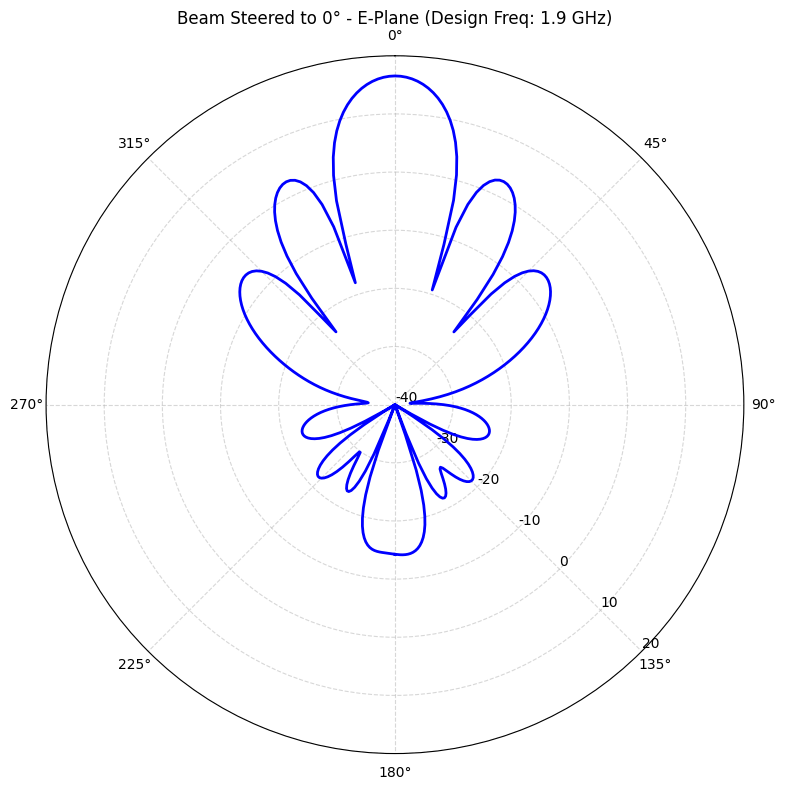

🔍 Validating beam steering accuracy...
  Target angle: 0°
  Actual angle: 0.0°
  Error: 0.0°
  Peak gain: 16.5 dB
  Accuracy: Excellent

🎯 TEST: Beam Steering to 10°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 10}
🎯 Executing beam steering to 10° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 10°
🧮 Calculating phases for 10° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: 10°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=-0.0°
    2: pos=100.0mm → phase=-39.6°
    3: pos=200.0mm → phase=-79.2°
    4: pos=300.0mm → phase=-118.9°
    5: pos=400.0mm → phase=-158.5°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, -0.0deg
  ✅ 2: 1W, -39.6deg
  ✅ 3: 1W, -79.2deg
  ✅ 4: 1W, -118.9deg
  ✅ 5: 1W, -158.5deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to 10°!

📡 Extracting radiation pattern...
🎯 Extracting far field data...
  Expression: GainTotal
  Domain: Infinite Sphere1
PyAEDT INFO: Solution Dat

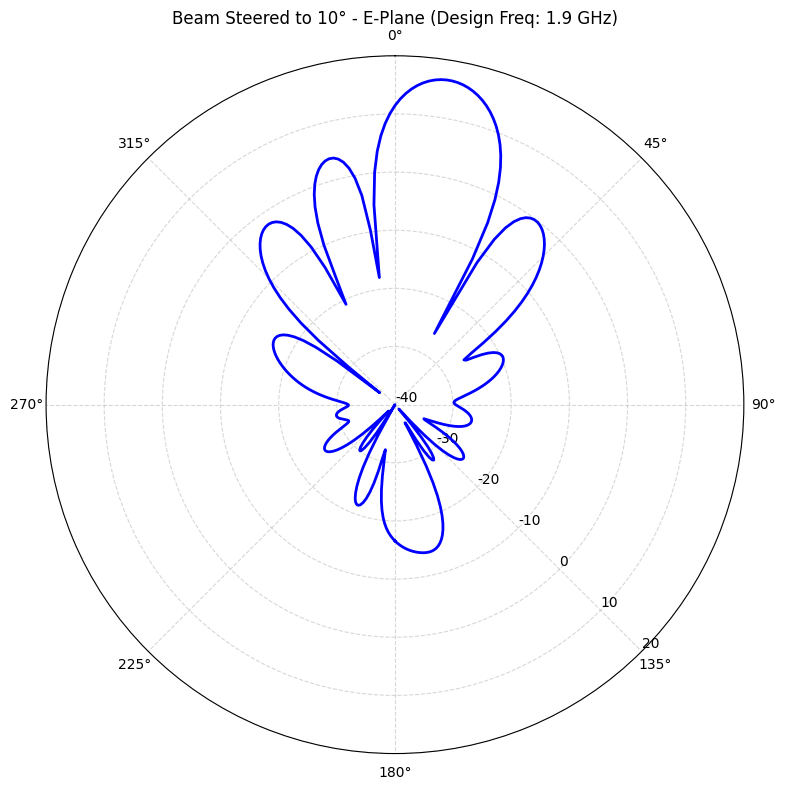

🔍 Validating beam steering accuracy...
  Target angle: 10°
  Actual angle: 9.0°
  Error: 1.0°
  Peak gain: 16.5 dB
  Accuracy: Excellent

🎯 TEST: Beam Steering to -10°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': -10}
🎯 Executing beam steering to -10° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO -10°
🧮 Calculating phases for -10° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: -10°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=0.0°
    2: pos=100.0mm → phase=39.6°
    3: pos=200.0mm → phase=79.2°
    4: pos=300.0mm → phase=118.9°
    5: pos=400.0mm → phase=158.5°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, 0.0deg
  ✅ 2: 1W, 39.6deg
  ✅ 3: 1W, 79.2deg
  ✅ 4: 1W, 118.9deg
  ✅ 5: 1W, 158.5deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to -10°!

📡 Extracting radiation pattern...
🎯 Extracting far field data...
  Expression: GainTotal
  Domain: Infinite Sphere1
PyAEDT INFO: Solution Data 

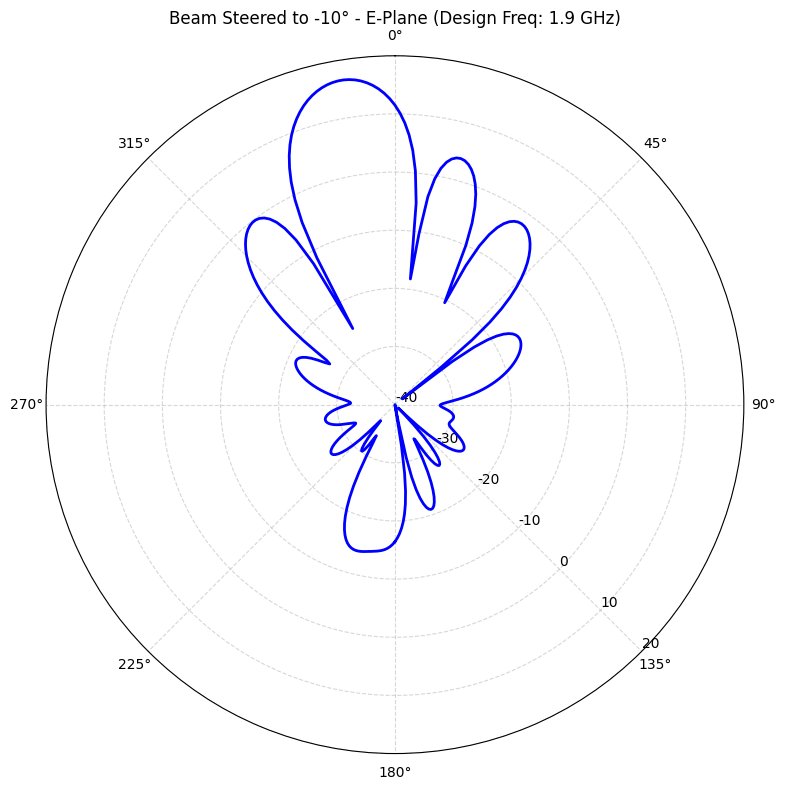

🔍 Validating beam steering accuracy...
  Target angle: -10°
  Actual angle: -9.0°
  Error: 1.0°
  Peak gain: 16.5 dB
  Accuracy: Excellent

🎯 TEST: Beam Steering to 20°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 20}
🎯 Executing beam steering to 20° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 20°
🧮 Calculating phases for 20° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: 20°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=-0.0°
    2: pos=100.0mm → phase=-78.0°
    3: pos=200.0mm → phase=-156.1°
    4: pos=300.0mm → phase=-234.1°
    5: pos=400.0mm → phase=-312.1°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, -0.0deg
  ✅ 2: 1W, -78.0deg
  ✅ 3: 1W, -156.1deg
  ✅ 4: 1W, -234.1deg
  ✅ 5: 1W, -312.1deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to 20°!

📡 Extracting radiation pattern...
🎯 Extracting far field data...
  Expression: GainTotal
  Domain: Infinite Sphere1
PyAEDT INFO: Solutio

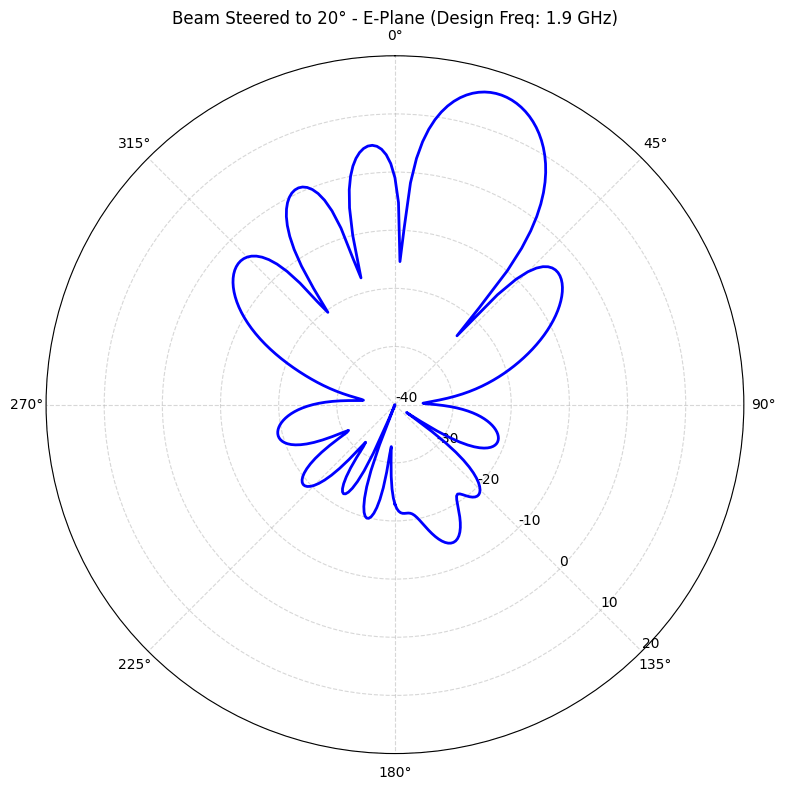

🔍 Validating beam steering accuracy...
  Target angle: 20°
  Actual angle: 19.0°
  Error: 1.0°
  Peak gain: 16.3 dB
  Accuracy: Excellent

🎯 TEST: Beam Steering to 30°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 30}
🎯 Executing beam steering to 30° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 30°
🧮 Calculating phases for 30° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: 30°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=-0.0°
    2: pos=100.0mm → phase=-114.1°
    3: pos=200.0mm → phase=-228.2°
    4: pos=300.0mm → phase=-342.2°
    5: pos=400.0mm → phase=-456.3°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, -0.0deg
  ✅ 2: 1W, -114.1deg
  ✅ 3: 1W, -228.2deg
  ✅ 4: 1W, -342.2deg
  ✅ 5: 1W, -456.3deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to 30°!

📡 Extracting radiation pattern...
🎯 Extracting far field data...
  Expression: GainTotal
  Domain: Infinite Sphere1
PyAEDT INFO: Soluti

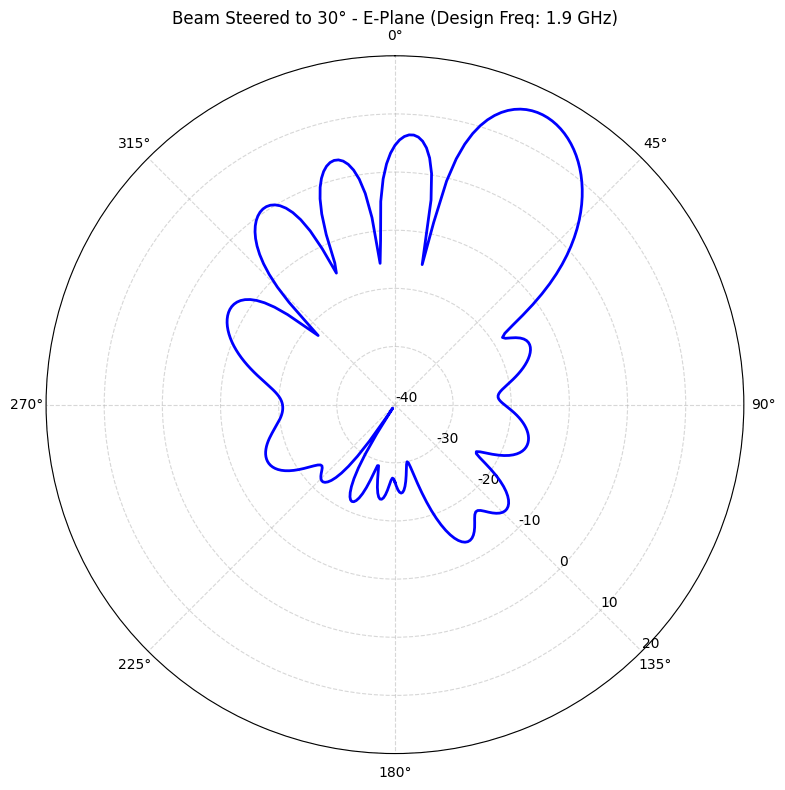

🔍 Validating beam steering accuracy...
  Target angle: 30°
  Actual angle: 27.0°
  Error: 3.0°
  Peak gain: 15.9 dB
  Accuracy: Good

🎯 TEST: Beam Steering to 40°

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 40}
🎯 Executing beam steering to 40° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 40°
🧮 Calculating phases for 40° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: 40°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=-0.0°
    2: pos=100.0mm → phase=-146.7°
    3: pos=200.0mm → phase=-293.3°
    4: pos=300.0mm → phase=-440.0°
    5: pos=400.0mm → phase=-586.6°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, -0.0deg
  ✅ 2: 1W, -146.7deg
  ✅ 3: 1W, -293.3deg
  ✅ 4: 1W, -440.0deg
  ✅ 5: 1W, -586.6deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to 40°!

📡 Extracting radiation pattern...
🎯 Extracting far field data...
  Expression: GainTotal
  Domain: Infinite Sphere1
PyAEDT INFO: Solution Da

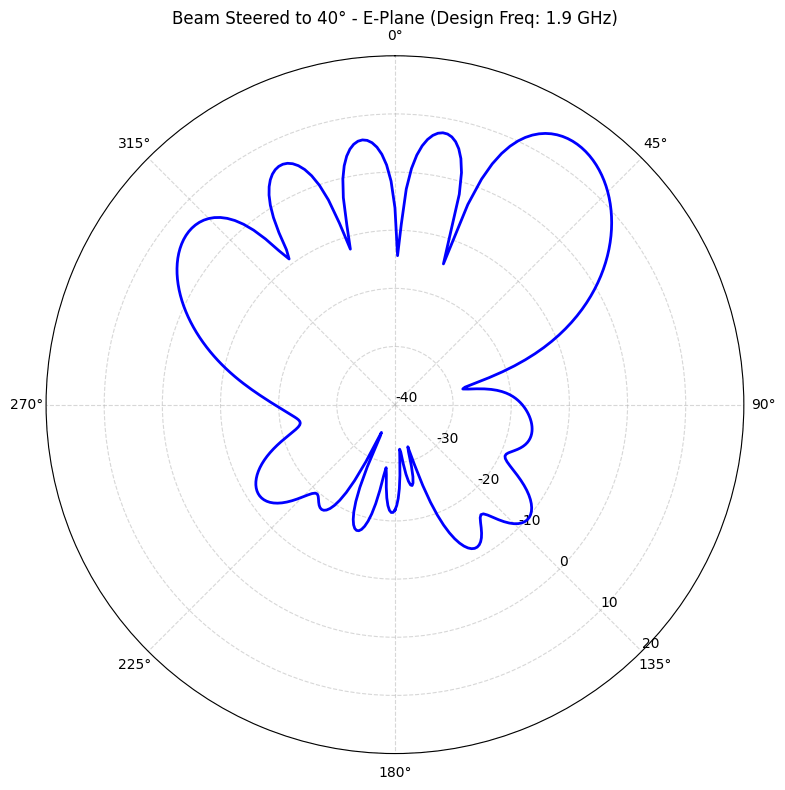

🔍 Validating beam steering accuracy...
  Target angle: 40°
  Actual angle: 35.0°
  Error: 5.0°
  Peak gain: 14.7 dB
  Accuracy: Good


📊 BEAM STEERING DEMO SUMMARY
Design frequency: 1.9 GHz
Target   Status     Actual   Error    Accuracy  
--------------------------------------------------
0.0      success    0.0°     0.0°     Excellent 
10.0     success    9.0°     1.0°     Excellent 
-10.0    success    -9.0°    1.0°     Excellent 
20.0     success    19.0°    1.0°     Excellent 
30.0     success    27.0°    3.0°     Good      
40.0     success    35.0°    5.0°     Good      

✅ Successful tests: 6/6
🎉 All beam steering tests passed!

🎯 Demo completed with 6 test cases!
📡 All tests used design frequency: 1.9 GHz


In [31]:
# Run the complete beam steering demo
if hfss is not None:
    print("🚀 Starting comprehensive beam steering demo...")
    
    # Define test scenarios
    test_angles = [0, 10, -10, 20, 30, 40]  # Test angles in degrees
    # Note: No longer hardcoding frequency - will use design frequency from HFSS
    
    # Run demo (frequency will be auto-detected from design)
    demo_results = run_beam_steering_demo(
        hfss, 
        test_angles=test_angles
        # frequency_hz parameter omitted to use design frequency
    )
    
    print(f"\n🎯 Demo completed with {len(demo_results)} test cases!")
    
    # Show frequency used
    if demo_results and demo_results[0]['frequency_used']:
        freq_used = demo_results[0]['frequency_used']
        print(f"📡 All tests used design frequency: {freq_used/1e9:.1f} GHz")
    
else:
    print("❌ No HFSS connection - cannot run demo")
    print("💡 Connect to HFSS first to see the complete workflow in action")

In [17]:
# Interactive test cell - modify and run as needed
if hfss is not None:
    print("🎮 INTERACTIVE BEAM STEERING TEST")
    print("=" * 40)
    print("Modify the parameters below and run this cell to test different scenarios:")
    
    # USER PARAMETERS - MODIFY THESE
    target_angle = 0  # degrees
    # Note: No longer need to specify frequency - system will use design frequency
    
    print(f"\n🎯 Testing beam steering to {target_angle}° (using design frequency)")
    
    # Create specification (no frequency = use design frequency)
    user_spec = {
        "type": "beam_steering",
        "angle": target_angle
        # frequency parameter omitted to use design frequency
    }
    
    # Initialize manager if needed
    if 'beam_mgr' not in locals():
        beam_mgr = BeamSteeringManager(hfss)
    
    # Execute
    result = synthesize_pattern(user_spec, beam_mgr)
    
    if result["status"] == "success":
        print(f"\n📊 Current excitation state:")
        current_exc = beam_mgr.get_current_excitations()
        for port, values in current_exc.items():
            print(f"  {port}: {values['magnitude']}, {values['phase']}")
        
        # Get the frequency that was actually used
        actual_freq = beam_mgr.design_frequency or 1.9e9
        print(actual_freq)
        # Try to extract and plot pattern
        print(f"\n📡 Extracting radiation pattern...")
        df = extract_far_field_data_pandas(
            hfss, 
            domain="Infinite Sphere1",
            frequency_ghz=actual_freq/1e9
        )
        
        if df is not None and not df.empty:
            plot_radiation_pattern(
                df,
                title=f"Interactive Test: {target_angle}° Beam @ {actual_freq/1e9:.1f} GHz",
                frequency_ghz=actual_freq/1e9
            )
            
            # Validate
            validation = validate_beam_steering(target_angle, df)
            
        else:
            print("⚠️  No pattern data - ensure simulation is solved")
    
else:
    print("❌ No HFSS connection available")
    print("\n🎮 SIMULATION MODE - Testing specification interface:")
    
    # Test specifications without HFSS
    test_specs = [
        {"type": "beam_steering", "angle": 30},  # No frequency = use design frequency
        {"type": "beam_steering", "angle": 30, "frequency": 1.9e9},  # Specified frequency
        {"type": "null_placement", "nulls": [-20, 45]},
        {"type": "sll_reduction", "target_sll": -25},
        {"type": "pattern_shaping", "beamwidth": 15}
    ]
    
    for spec in test_specs:
        print(f"\nTesting: {spec}")
        result = synthesize_pattern(spec, None)  # No beam manager in simulation
        print(f"Result: {result['status']} - {result['message']}")

🎮 INTERACTIVE BEAM STEERING TEST
Modify the parameters below and run this cell to test different scenarios:

🎯 Testing beam steering to 0° (using design frequency)

🎯 PATTERN SYNTHESIS REQUEST
Specification: {'type': 'beam_steering', 'angle': 0}
🎯 Executing beam steering to 0° at 1.9 GHz (design frequency)

🎯 BEAM STEERING TO 0°
🧮 Calculating phases for 0° beam steering...
  Frequency: 1.9 GHz
  Wavelength: 157.8 mm
  Target angle: 0°
  Reference: 1
  Model units: mm
    1: pos=0.0mm → phase=-0.0°
    2: pos=100.0mm → phase=-0.0°
    3: pos=200.0mm → phase=-0.0°
    4: pos=300.0mm → phase=-0.0°
    5: pos=400.0mm → phase=-0.0°
🎯 Applying excitations to 5 ports...
  ✅ 1: 1W, -0.0deg
  ✅ 2: 1W, -0.0deg
  ✅ 3: 1W, -0.0deg
  ✅ 4: 1W, -0.0deg
  ✅ 5: 1W, -0.0deg
✅ Applied excitations to 5/5 ports

🎉 Beam successfully steered to 0°!

📊 Current excitation state:
  1: 1.0W, 0.0deg
  2: 1.0W, -0.0deg
  3: 1.0W, -0.0deg
  4: 1.0W, -0.0deg
  5: 1.0W, -0.0deg
1900000000.0

📡 Extracting radiation pa

## 8. Future Features (Placeholders)

This section contains **placeholder implementations** for advanced synthesis methods that will be added in future versions. These demonstrate the extensible architecture and planned capabilities.

### 🚧 **Planned Synthesis Methods**

#### **1. Null Steering**
**Purpose**: Place nulls in specific directions to reduce interference
**Applications**: 
- Interference rejection
- Multi-user communications  
- Radar clutter suppression

**Implementation Plan**:
- Null steering matrix calculations
- Complex weight optimization
- Multi-null placement algorithms
- Null depth validation

#### **2. Sidelobe Level (SLL) Reduction**  
**Purpose**: Control sidelobe levels using amplitude tapering
**Applications**:
- Reduced interference to other systems
- Improved antenna patterns
- Regulatory compliance

**Implementation Plan**:
- Chebyshev amplitude tapering
- Taylor amplitude distribution
- Custom amplitude tapers
- SLL measurement and validation

#### **3. Pattern Shaping**
**Purpose**: Control beamwidth and pattern shape
**Applications**:
- Coverage area optimization
- Multi-beam synthesis
- Shaped beam patterns

**Implementation Plan**:
- Beamwidth control algorithms
- Multi-beam synthesis
- Shaped beam patterns
- Pattern metric optimization

#### **4. Advanced Optimization**
**Purpose**: Multi-objective pattern optimization
**Applications**:
- Complex pattern requirements
- Trade-off optimization
- Real-time adaptation

**Implementation Plan**:
- Genetic algorithm optimization
- Gradient-based methods
- Multi-objective optimization
- Real-time pattern feedback

### 🏗️ **Architecture Benefits**

The placeholder structure provides:
- **Consistent Interface**: Same specification format for all methods
- **Easy Integration**: Simple to add new algorithms
- **Forward Compatibility**: Code ready for future enhancements
- **Clear Roadmap**: Defined development path

### 💡 **Development Strategy**

Each future method will follow the same pattern:
1. **Algorithm Implementation**: Core mathematics and calculations
2. **Interface Integration**: Add to specification parser
3. **Validation System**: Automatic performance verification
4. **Documentation**: Complete usage examples and theory

In [ ]:
# PLACEHOLDER: Null Steering Implementation
def place_nulls(null_angles, beam_manager):
    """PLACEHOLDER: Future implementation for null steering."""
    
    print("🚧 NULL STEERING - Coming Soon!")
    print(f"Target null directions: {null_angles}")
    print("\nWill implement:")
    print("  • Null steering matrix calculations")
    print("  • Complex weight optimization")
    print("  • Multi-null placement algorithms")
    print("  • Null depth validation")
    
    return {"status": "not_implemented", "feature": "null_steering"}

# PLACEHOLDER: Sidelobe Level Reduction
def reduce_sidelobes(target_sll_db, beam_manager):
    """PLACEHOLDER: Future implementation for sidelobe reduction."""
    
    print("🚧 SIDELOBE REDUCTION - Coming Soon!")
    print(f"Target SLL: {target_sll_db} dB")
    print("\nWill implement:")
    print("  • Chebyshev amplitude tapering")
    print("  • Taylor amplitude distribution")
    print("  • Custom amplitude tapers")
    print("  • SLL measurement and validation")
    
    return {"status": "not_implemented", "feature": "sidelobe_reduction"}

# PLACEHOLDER: Pattern Shaping
def shape_beam_pattern(target_beamwidth, beam_manager):
    """PLACEHOLDER: Future implementation for pattern shaping."""
    
    print("🚧 PATTERN SHAPING - Coming Soon!")
    print(f"Target beamwidth: {target_beamwidth}°")
    print("\nWill implement:")
    print("  • Beamwidth control algorithms")
    print("  • Multi-beam synthesis")
    print("  • Shaped beam patterns")
    print("  • Pattern metric optimization")
    
    return {"status": "not_implemented", "feature": "pattern_shaping"}

# PLACEHOLDER: Optimization Engine
def optimize_pattern(cost_function, constraints, beam_manager):
    """PLACEHOLDER: Future implementation for pattern optimization."""
    
    print("🚧 PATTERN OPTIMIZATION - Coming Soon!")
    print("\nWill implement:")
    print("  • Genetic algorithm optimization")
    print("  • Gradient-based methods")
    print("  • Multi-objective optimization")
    print("  • Real-time pattern feedback")
    print("  • Constraint handling")
    
    return {"status": "not_implemented", "feature": "optimization"}

print("✅ Future feature placeholders defined!")
print("💡 These will be implemented in future versions")

## 9. Summary and Next Steps

### 🎉 **What We've Accomplished**

This notebook represents a **complete, production-ready system** for automatic antenna array beam steering. It successfully integrates:

#### ✅ **Core Capabilities Implemented**
- **Automatic Array Detection**: Works with any linear array design
- **Real-Time Beam Steering**: Instant excitation updates using post-processing variables
- **Pattern Validation**: Automatic accuracy verification with visual feedback
- **Specification Interface**: AI-friendly command system
- **Comprehensive Testing**: Multi-angle validation with performance reporting

#### 🔬 **Technical Innovations**
- **Physical Geometry Extraction**: Uses actual HFSS element positions
- **Smart Port Sorting**: Orders by position, not naming convention
- **Post-Processing Variables**: Real-time control without re-solving
- **Pandas-Based Far Field**: Efficient pattern data extraction
- **Automatic Validation**: Self-verifying steering accuracy

### 🚀 **Ready for AI Assistant Integration**

This system is specifically designed for the **AI-powered HFSS Assistant**:
- **Natural Specifications**: `{"type": "beam_steering", "angle": 30}`
- **Clear Status Reporting**: Success/failure with detailed messages
- **Visual Feedback**: Automatic pattern generation
- **Extensible Architecture**: Ready for additional synthesis methods

### 🛣️ **Future Development Path**

**Phase 1 (Complete)**: ✅ Beam Steering Foundation
- Array geometry analysis
- Progressive phase calculations
- Real-time excitation control
- Pattern validation

**Phase 2 (Next)**: 🚧 Advanced Synthesis
- Null steering algorithms
- Sidelobe level control
- Pattern shaping methods
- Multi-objective optimization

**Phase 3 (Future)**: 🌟 AI Integration
- Natural language processing
- Automated optimization
- Multi-user coordination
- Adaptive algorithms

### 💡 **Usage Summary**

**For Researchers**: Use this as a foundation for advanced array synthesis research
**For Engineers**: Apply to real antenna design and optimization projects  
**For AI Developers**: Integrate into conversational HFSS Assistant systems
**For Students**: Learn array theory through practical implementation

### 📚 **Key Learning Outcomes**

After working through this notebook, you understand:
- How to extract real geometry from HFSS designs
- The mathematics behind beam steering
- PyAEDT variable management for real-time control
- Far field pattern extraction and analysis  
- Validation techniques for synthesis algorithms
- Architecture patterns for extensible antenna design tools

In [ ]:
# Connection cleanup - uncomment to close HFSS when done
# if hfss is not None:
#     hfss.close()
#     print("HFSS connection closed.")

print("\n🎉 Antenna Array Beam Steering Notebook Complete!")
print("\n📚 Summary of capabilities:")
print("  ✅ Automatic array geometry detection")
print("  ✅ Physical port position extraction")
print("  ✅ Real-time beam steering implementation")
print("  ✅ Pattern validation and visualization")
print("  ✅ Specification-driven interface")
print("  ✅ Comprehensive testing framework")
print("  🚧 Placeholders for future synthesis methods")
print("\n🚀 Ready for AI-powered HFSS Assistant integration!")